#Transfer Learning in TensorFlow Frame
This notebook presents experiments with transfer learning of VGG16 and ResNet152 models in TensorFlow framework. The results can be compared with code for similar task in PyTorch framework (presented in PyTorch&TransferLearning.ipynb).

The image bank for the experiments and the code for loading it were borrowed from one of the notebooks of the Deep Learning course from YData Data Science School.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import requests
from zipfile import ZipFile
import os
from time import time
import datetime
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import gc

import torch
import torchvision

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Check for the availability of a GPU

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    device = gpus[0]
    tf.config.experimental.set_memory_growth(device, True)
else:
    device = 'CPU'

print(device)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


###1. Load Data

In [ ]:
# Create a folder for our data
!mkdir data
!mkdir data/israeli_politicians

# Download our dataset and extract it
url = 'https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('./data/israeli_politicians.zip', 'wb').write(r.content)

with ZipFile('./data/israeli_politicians.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='./data/israeli_politicians/')

### 2. Preprocess the data and create TensorFlow data generators (dataloaders)

In [ ]:
# Parameters for data generators (including preprocessing)
# The input image size for pre-trained VGG16 and ResNet152 from TensorFlow libraries is 224 x 224.

DATA_DIR = r'./data/israeli_politicians/'
IMAGE_SIZE = 224
NUM_CLASSES = 9

MODEL_NAME = "tf_VGG16" # this variable determines which pre-trained TensorFlow model will be used in the code (tf_VGG16 or tf_ResNet152)

# Function to choose preprocess_input for VGG16 or ResNet152
if MODEL_NAME == "tf_VGG16":
    preprocess_var = vgg_preprocess_input # normalization with means = [103.939, 116.779, 123.68] and chanels change from RGB to BGR
    means = [103.939, 116.779, 123.68] # VGG16 means used in keras for normalization R: 103.939, G: 116.779, B: 123.68
elif MODEL_NAME == "tf_ResNet152":
    preprocess_var = resnet_preprocess_input # scaling to [-1,1] and chanels change from RGB to BGR
else:
    print("The selected model must be VGG16 or ResNet152")

In [ ]:
# Create data generators

train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_var,
    rotation_range=10,
    width_shift_range=0.1,       # Horizontal shift up to 10% of image size
    height_shift_range=0.1,      # Vertical shift up to 10% of image size
    horizontal_flip=True
    )

val_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_var
    )

train_generator = train_data_generator.flow_from_directory(
        os.path.join(DATA_DIR, 'train'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=16,
        class_mode='sparse')

validation_generator = val_data_generator.flow_from_directory(
        os.path.join(DATA_DIR, 'val'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        class_mode='sparse')

Found 929 images belonging to 9 classes.
Found 234 images belonging to 9 classes.


### 3. Get information about images and batches and visualize a few images

In [ ]:
# Fetch a single batch of data from the generator
inputs, classes = next(train_generator)

print('A sample batch info')
print('- shape:           ', inputs.shape)  # Shape of the images in the batch
print('- labels of classes', classes)       # Labels for the batch

# Assuming `class_indices` is the mapping of class indices to class names
class_names = list(train_generator.class_indices.keys())
print('\nThe class names in the batch:')
print([class_names[int(c)] for c in classes])

# Information about images
print('\nMin value of pixels in the batch:', tf.reduce_min(inputs))
print('Max value of pixels in the batch:', tf.reduce_max(inputs))


A sample batch info
- shape:            (16, 224, 224, 3)
- labels of classes [7. 1. 0. 3. 0. 1. 6. 6. 8. 1. 1. 1. 7. 2. 7. 3.]

The class names in the batch:
['ofir_akunis', 'benjamin_netanyahu', 'ayelet_shaked', 'danny_danon', 'ayelet_shaked', 'benjamin_netanyahu', 'naftali_bennett', 'naftali_bennett', 'yair_lapid', 'benjamin_netanyahu', 'benjamin_netanyahu', 'benjamin_netanyahu', 'ofir_akunis', 'benny_gantz', 'ofir_akunis', 'danny_danon']

Min value of pixels in the batch: tf.Tensor(-123.68, shape=(), dtype=float32)
Max value of pixels in the batch: tf.Tensor(151.061, shape=(), dtype=float32)


In [ ]:
# Modified function to show an image from PyTorch or TensorFlow tensors

def imshow(inp, frame, title=None):

    if frame == "pt": # this frame used in case of the PyTorch VGG16 and ResNet152 pretrained models
        inp = inp.numpy()
        inp = inp.transpose((1, 2, 0))
        mean = np.array(means)
        std = np.array(stds)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    elif frame == "tf_VGG16": # this frame used in case of the TensorFlow VGG16 pretrained model
        inp = inp.numpy()
        inp = inp[::-1,...] # in case of TensorFlow we have to change back chanels from BGR to RGB
        inp = inp.transpose((1, 2, 0))
        mean = np.array(means)
        inp = (inp + mean)/255.0
        inp = np.clip(inp, 0, 1)

    elif frame == "tf_ResNet152": # this frame used in case of the TensorFlow ResNet152 pretrained model
        inp = inp.numpy()
        inp = inp.transpose((1, 2, 0))
        inp = (inp + 1)/2
        inp = np.clip(inp, 0, 1)

    else:
        raise ValueError("Input tensor must be a PyTorch or TensorFlow (tensor after preprocessing for keras VGG16/ResNet152).")

    fig = plt.figure(figsize=(5, 3), dpi=300)
    plt.imshow(inp)

    if title is not None:
        plt.title(title, fontsize=5)

    plt.pause(0.001)  # pause a bit so that plots are updated

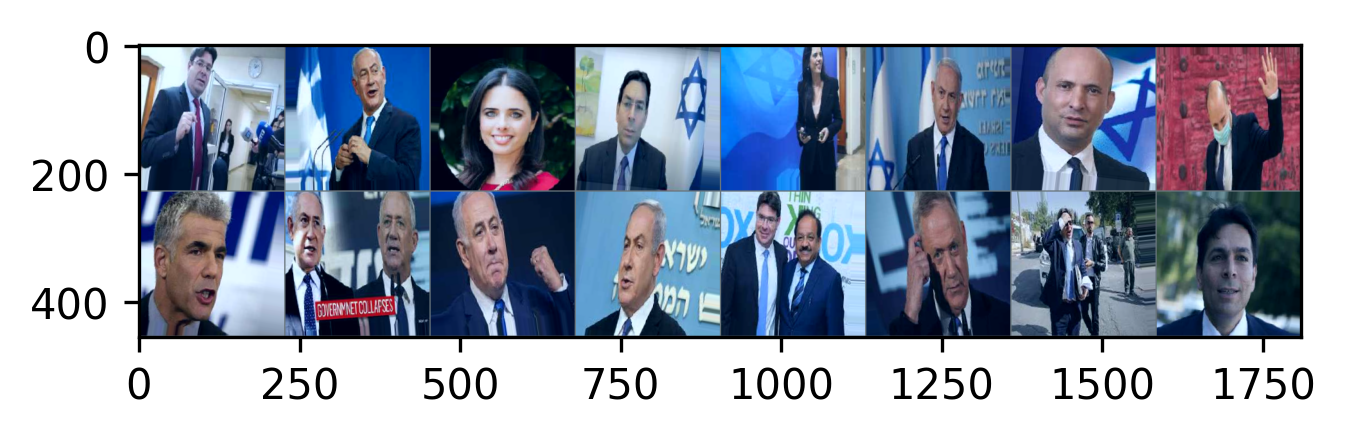

In [ ]:
inputs_pt = torch.tensor(inputs)
inputs_pt = inputs_pt.permute(0, 3, 1, 2)
out = torchvision.utils.make_grid(inputs_pt, nrow=8, )

imshow(out, MODEL_NAME)

### 4. Load and setup pretrained model (VGG16 or ResNet152)

In [ ]:
# If needed, delete previously loaded model from memory
del model, base_model
gc.collect()

# Clear any logs from previous runs
!rm -rf ./logs/

# Clear the current TensorFlow session to remove optimizer parameters
tf.keras.backend.clear_session()

In [ ]:
# Load a pretrained VGG16 or ResNet model with its weights according to MODEL_NAME

if MODEL_NAME == "tf_VGG16":
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
elif MODEL_NAME == "tf_ResNet152":
    base_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False)
else:
    print("The selected model must be VGG16 or ResNet152")

In [ ]:
# Model summary
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Define functions for finetuning the model

In [ ]:
# Function to freeze layers in base model according to MODEL_NAME and finetuning strategy
# Possible strategies:
#  'finetuning' - all layers trainable (by default),
#  'half_freeze' - only last 50% layers trainable,
#  'threeQ_freeze' - only last 25% layers trainabel,
#  'feature_extraction' - only classifier head trainable

def freeze_layers_strategy(strategy):
    if strategy == "feature_extraction":
        n = len(base_model.layers)
    elif strategy == "half_freeze":
        n = len(base_model.layers) // 2
    elif strategy == "threeQ_freeze":
        n = 3 * len(base_model.layers) // 4
    elif strategy == "finetuning":
        n = 0

    for layer in base_model.layers[:n]:
        layer.trainable = False

In [ ]:
# Function to create model based on base_model

def create_model(base_model, just_one_dense = True):

  tf.keras.backend.clear_session()

  inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  x = base_model(inputs)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  if just_one_dense == False:
      x = tf.keras.layers.Dropout(0.2)(x)
      x = tf.keras.layers.Dense(256, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
# Function to define loss and optimizer

def create_optimizer_loss(learning_rate, momentum):
  # As loss function for a multi-class problem:
  #loss = 'CategoricalCrossentropy'
  loss = 'sparse_categorical_crossentropy'

  optimizer = tf.keras.optimizers.SGD(learning_rate, momentum)

  return optimizer, loss

In [ ]:
# Function to train model

def train_model_generators(model, generators, optimizer, loss, num_epochs):
    since = time()

    # Compiling a model with metrics
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['sparse_categorical_accuracy'])

    # Setting up callbacks to save the best model
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras', monitor='val_sparse_categorical_accuracy', save_best_only=True)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Learning the model with validation
    history = model.fit(
                        generators['train'],
                        validation_data=generators['val'],
                        epochs=num_epochs,
                        callbacks=[checkpoint_cb, tensorboard_cb])


    time_elapsed = time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')

    return model, history

### 6. Finetune the model

In [ ]:
# a. Layers in the model head:
# just_one_dense = True - only one dense fc layer will be added to the head without dropout (as it is in PyTorch framework)
# just_one_dense = False - two dense layers will be added to the head with dropout (0.2 for the 1st one and 0.5 for the 2nd one)

just_one_dense = True

# b. Training strategies:
# 'finetuning' - all layers trainable (by default),
# 'half_freeze' - only last 50% layers trainable,
# 'threeQ_freeze' - only last 25% layers trainabel,
# 'feature_extraction' - only classifier head trainable

strategy = 'finetuning'
freeze_layers_strategy(strategy)

# c. Number of epochs, learning rate, momentum

num_epochs = 10
learning_rate=0.0001
momentum = 0.9

# d. Create model, define an optimizer and loss function, train the model

model = create_model(base_model)
optimizer, loss = create_optimizer_loss(learning_rate, momentum)
model_finetuned, history = train_model_generators(model, {'train': train_generator, 'val': validation_generator}, optimizer, loss, num_epochs)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 400ms/step - loss: 3.4549 - sparse_categorical_accuracy: 0.1868 - val_loss: 1.9607 - val_sparse_categorical_accuracy: 0.2906
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 363ms/step - loss: 1.8735 - sparse_categorical_accuracy: 0.3235 - val_loss: 1.7104 - val_sparse_categorical_accuracy: 0.4145
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - loss: 1.5223 - sparse_categorical_accuracy: 0.5018 - val_loss: 1.4890 - val_sparse_categorical_accuracy: 0.5085
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 353ms/step - loss: 1.1537 - sparse_categorical_accuracy: 0.5982 - val_loss: 1.2401 - val_sparse_categorical_accuracy: 0.5598
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - loss: 0.9112 - sparse_categorical_accuracy: 0.7040 - val_loss: 1.1434 - val_sparse_categorical_accuracy: 0.6282
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - loss: 0.7268 - sparse_categorical_accuracy: 0.7468 - val_loss: 1.0989 - val_sparse_categorical_accuracy: 0.662

###7. Evaluate: plot the finetuned model convergence for different experiments

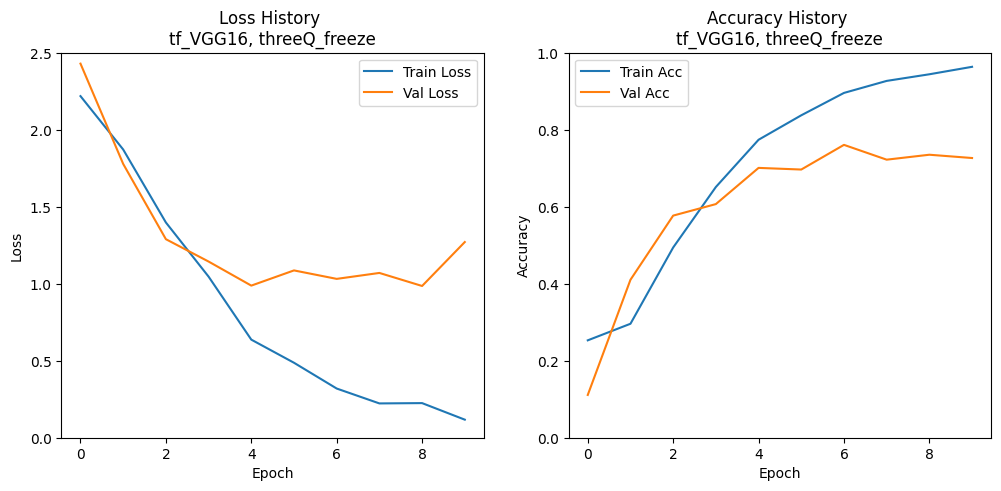

In [ ]:
# Plot loss and accuracy history
# VGG16
# just one dense layer in the head without drop out
# strategy = 'threeQ_freeze'
# lr = 0.001

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss History \n{MODEL_NAME}, {strategy}')
plt.ylim(0, 2.5)

plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy History \n{MODEL_NAME}, {strategy}')
plt.ylim(0, 1)

plt.show()

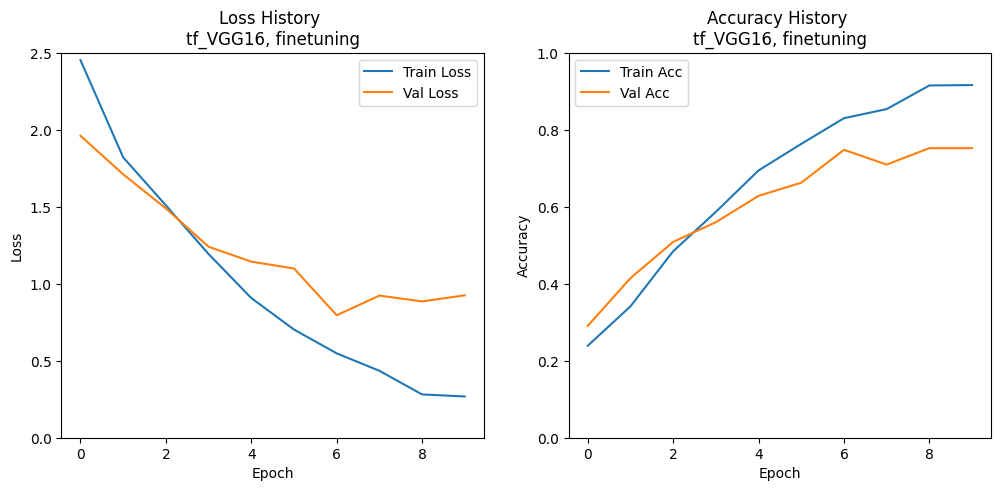

In [ ]:
# Plot loss and accuracy history
# VGG16
# just one dense layer in the head without drop out
# strategy = 'finetuning'
# lr = 0.0001

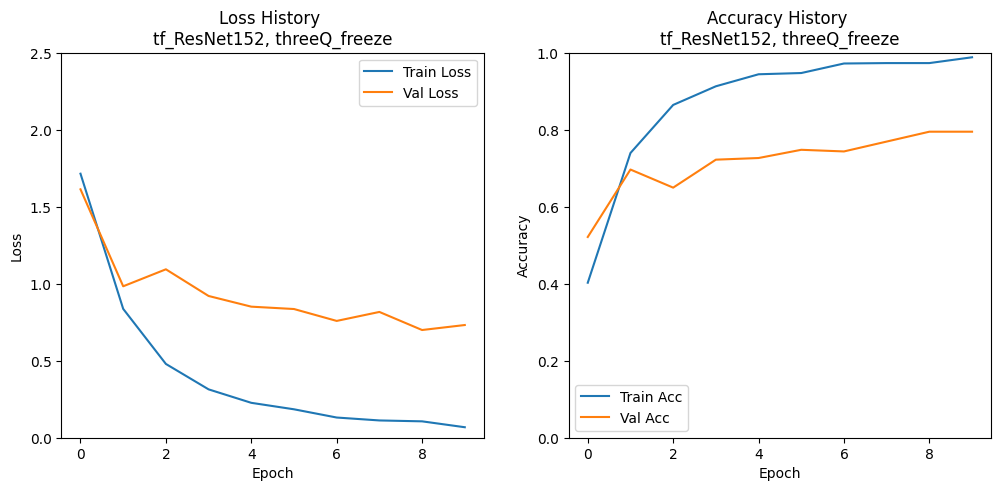

In [ ]:
# Plot loss and accuracy history
# ResNet152
# just one dense layer in the head without drop out
# strategy = 'threeQ_freeze'
# lr = 0.001

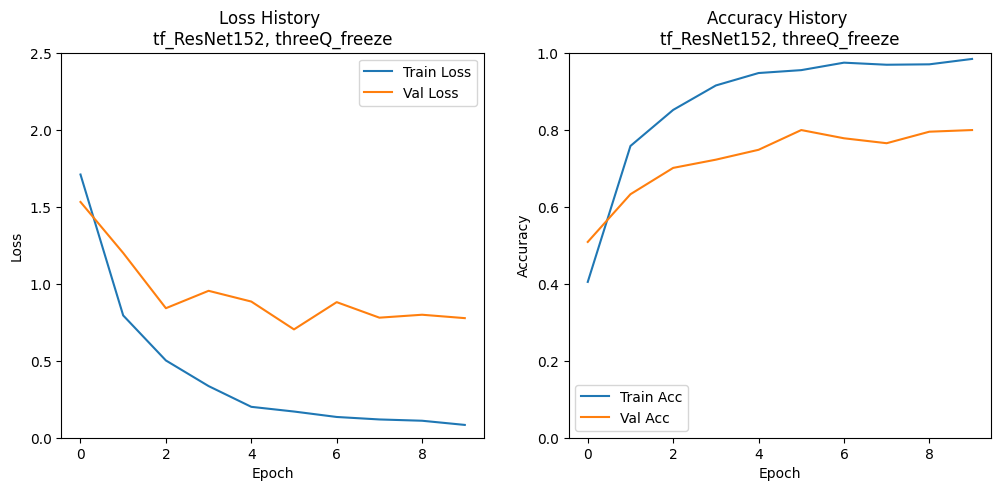

In [ ]:
# Plot loss and accuracy history
# ResNet152
# two dense layers in the head with drop out
# strategy = 'threeQ_freeze' (75%)
# lr = 0.001

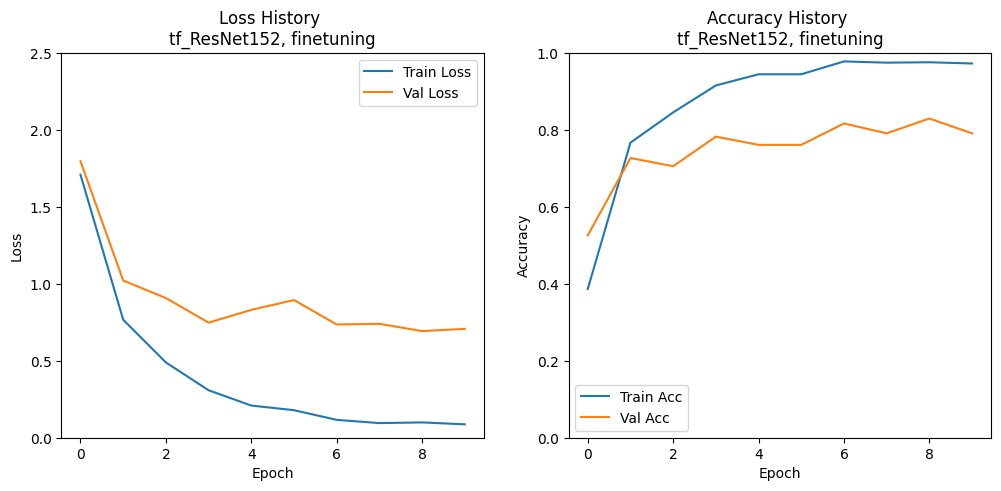

In [ ]:
# Plot loss and accuracy history
# ResNet152
# two dense layers in the head with drop out
# strategy = 'finetuning' (75%)
# lr = 0.001

###8. Evaluate: get the finetuned model performance

In [ ]:
def predict_classes(model, data_generator, steps):
    real_classes = []
    predicted_classes = []

    for i, (inputs, labels) in enumerate(data_generator):
        if i >= steps:
            break

        outputs = model(inputs, training=False)
        predicted = np.argmax(outputs, axis=1)

        real_classes.extend(labels)
        predicted_classes.extend(predicted)

    return real_classes, predicted_classes

In [ ]:
steps = len(validation_generator)
real_classes, predicted_classes = predict_classes(model_finetuned, validation_generator, steps)

# Get the classification report
print("Classification Report:\n")
print(classification_report(real_classes, predicted_classes))

# Get the confusion matrix
print("\nConfusion Matrix:\n")
print(confusion_matrix(real_classes, predicted_classes))

Classification Report:

              precision    recall  f1-score   support

         0.0       0.75      0.69      0.72        26
         1.0       0.83      0.85      0.84        53
         2.0       0.67      0.33      0.44        24
         3.0       0.78      0.72      0.75        25
         4.0       0.59      0.83      0.69        23
         5.0       0.00      0.00      0.00         2
         6.0       0.62      0.88      0.73        26
         7.0       0.87      0.72      0.79        36
         8.0       0.90      0.95      0.92        19

    accuracy                           0.75       234
   macro avg       0.67      0.66      0.65       234
weighted avg       0.76      0.75      0.74       234


Confusion Matrix:

[[18  0  0  2  2  0  2  1  1]
 [ 0 45  4  0  3  0  1  0  0]
 [ 1  6  8  0  0  0  8  0  1]
 [ 3  0  0 18  2  0  0  2  0]
 [ 0  1  0  2 19  0  0  1  0]
 [ 0  0  0  0  1  0  1  0  0]
 [ 1  0  0  0  0  2 23  0  0]
 [ 1  2  0  1  4  0  2 26  0]
 [ 0  0  0 

### 9. Error Analysis

In [ ]:
def get_errors(model, data_generator, steps):

    incorrect_images = []

    for i, (inputs, labels) in enumerate(data_generator):
        if i >= steps:
           break

        outputs = model(inputs, training=False)

        probs = tf.nn.softmax(outputs, axis=1)

        preds = tf.argmax(outputs, axis=1)

        for j in range(inputs.shape[0]):
            if preds[j] != labels[j]:
                #incorrect_images.append((inputs[j].numpy(), preds[j].numpy(), labels[j].numpy(), probs[j].numpy()))
                incorrect_images.append((inputs[j], preds[j], labels[j], probs[j]))

    return incorrect_images


In [ ]:
# The function to plot the top-10 error images and to get information about them

def top_incorrect_images(incorrect_images, class_names, MODEL_NAME, top_n=10):

    sorted_images = sorted(incorrect_images, key=lambda x: max(x[3]), reverse=True)

    for i in range(min(top_n, len(sorted_images))):
        image, pred_class, true_class, probs = sorted_images[i]
        confidence = probs[pred_class]
        print(f"Image {i+1}: Predicted Class: {class_names[pred_class]}, True Class: {class_names[int(true_class)]}, Confidence: {confidence:.4f}")

        image = torch.tensor(image)
        image = image.permute(2, 0, 1)
        imshow(image, MODEL_NAME)

Image 1: Predicted Class: benjamin_netanyahu, True Class: ofir_akunis, Confidence: 0.2513


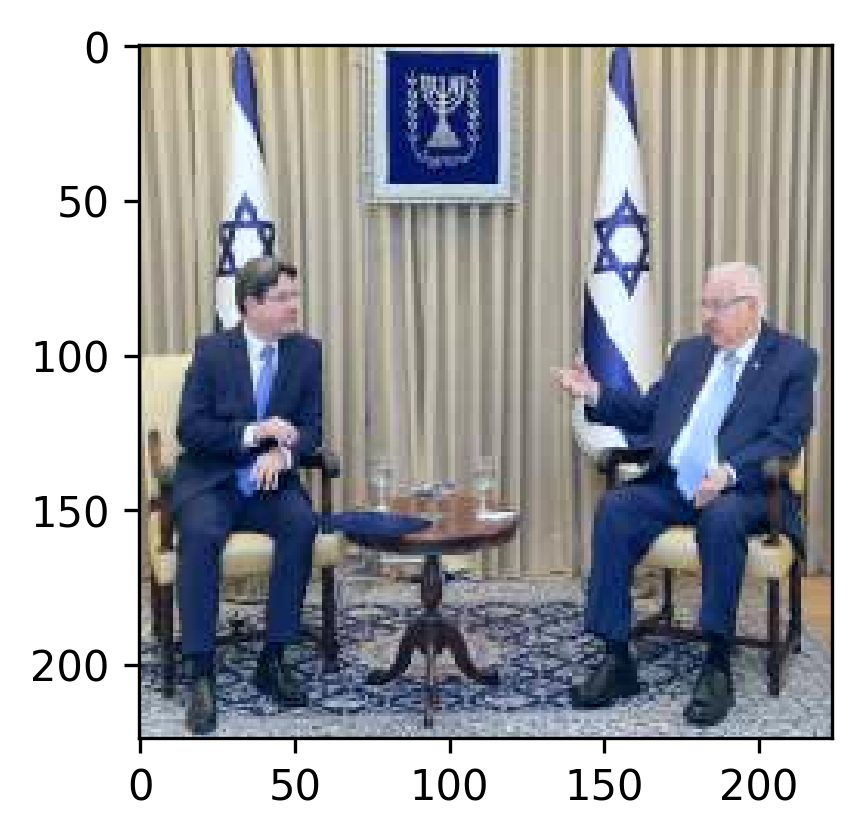

Image 2: Predicted Class: benjamin_netanyahu, True Class: benny_gantz, Confidence: 0.2495


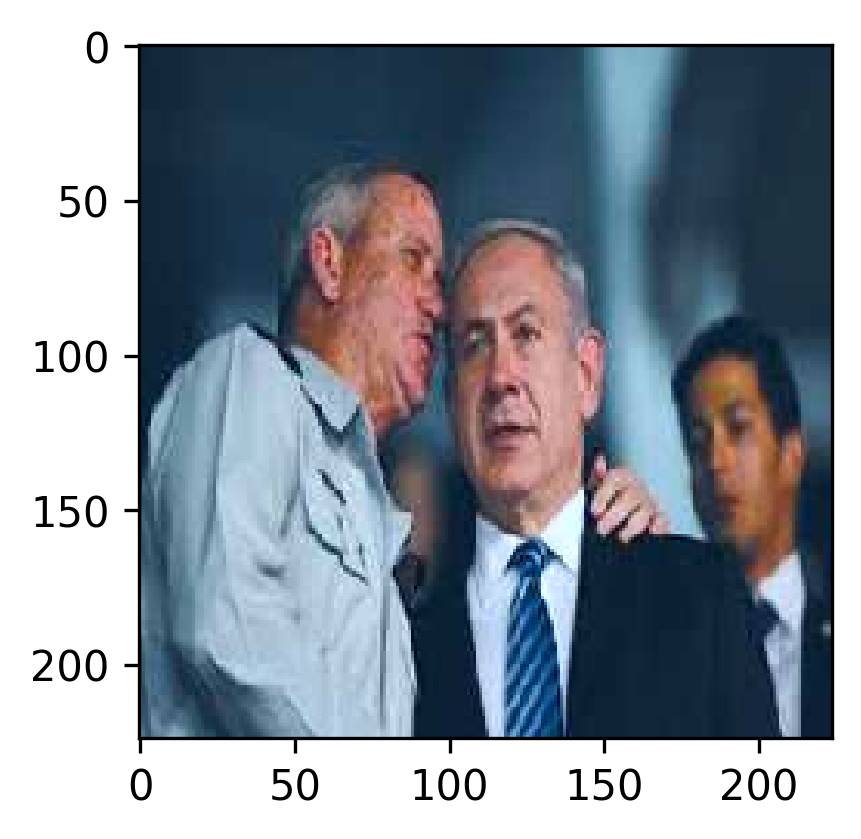

Image 3: Predicted Class: naftali_bennett, True Class: benny_gantz, Confidence: 0.2454


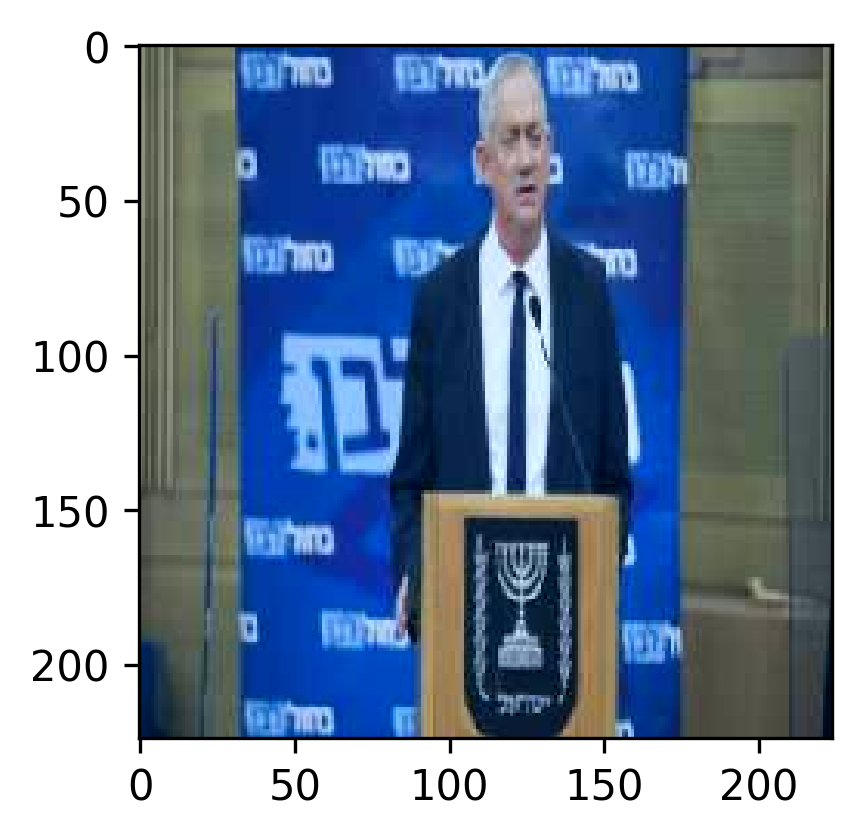

Image 4: Predicted Class: naftali_bennett, True Class: benny_gantz, Confidence: 0.2399


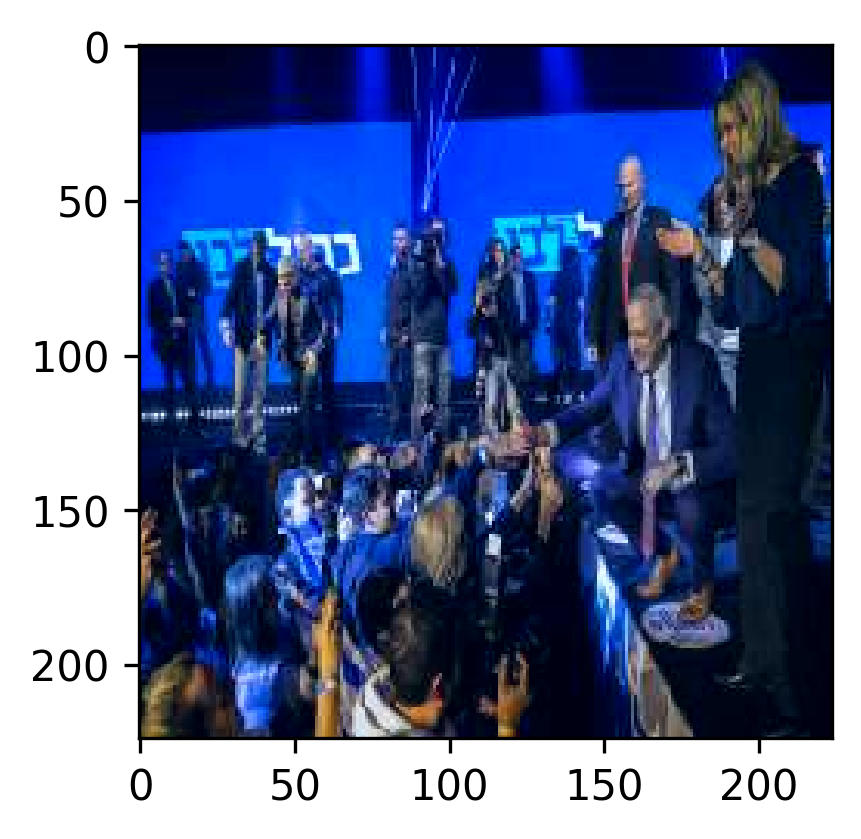

Image 5: Predicted Class: kostya_kilimnik, True Class: naftali_bennett, Confidence: 0.2397


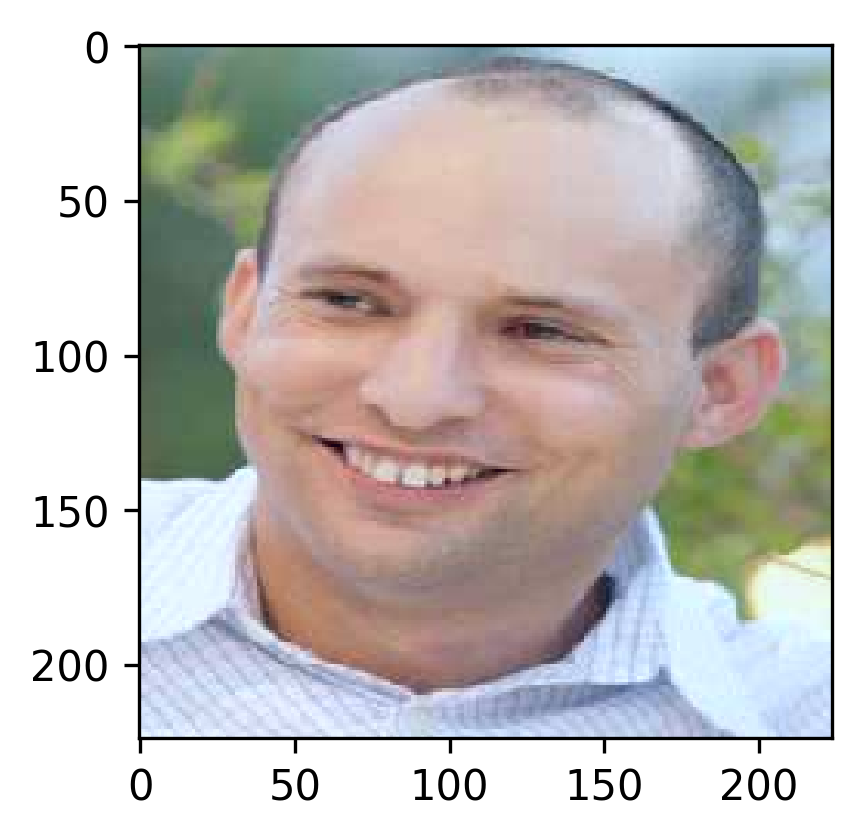

Image 6: Predicted Class: ofir_akunis, True Class: danny_danon, Confidence: 0.2387


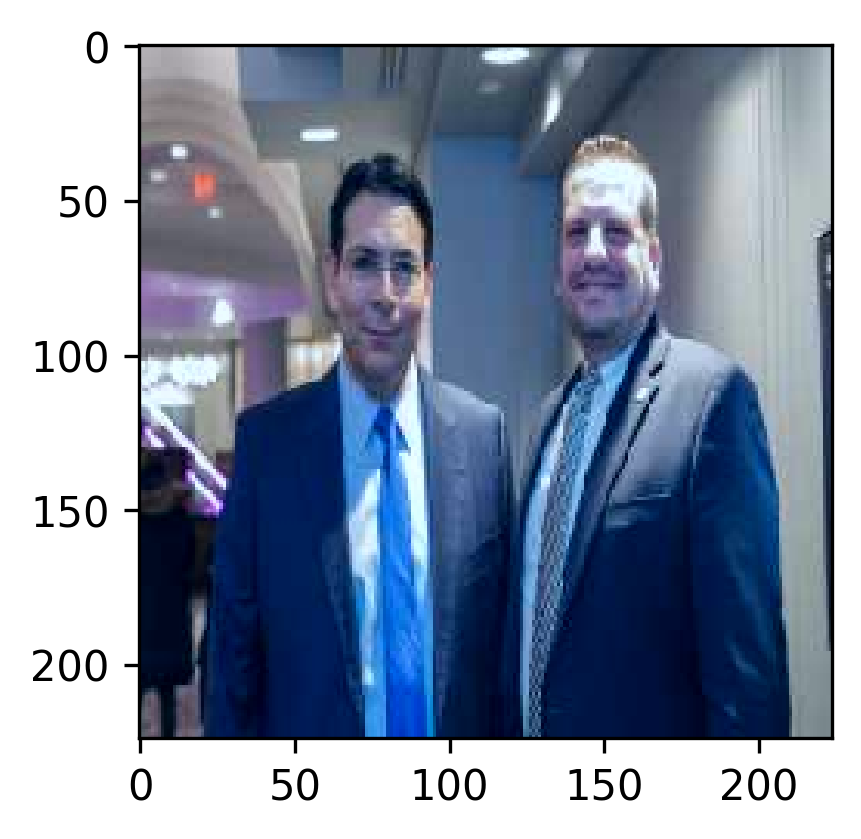

Image 7: Predicted Class: ofir_akunis, True Class: danny_danon, Confidence: 0.2387


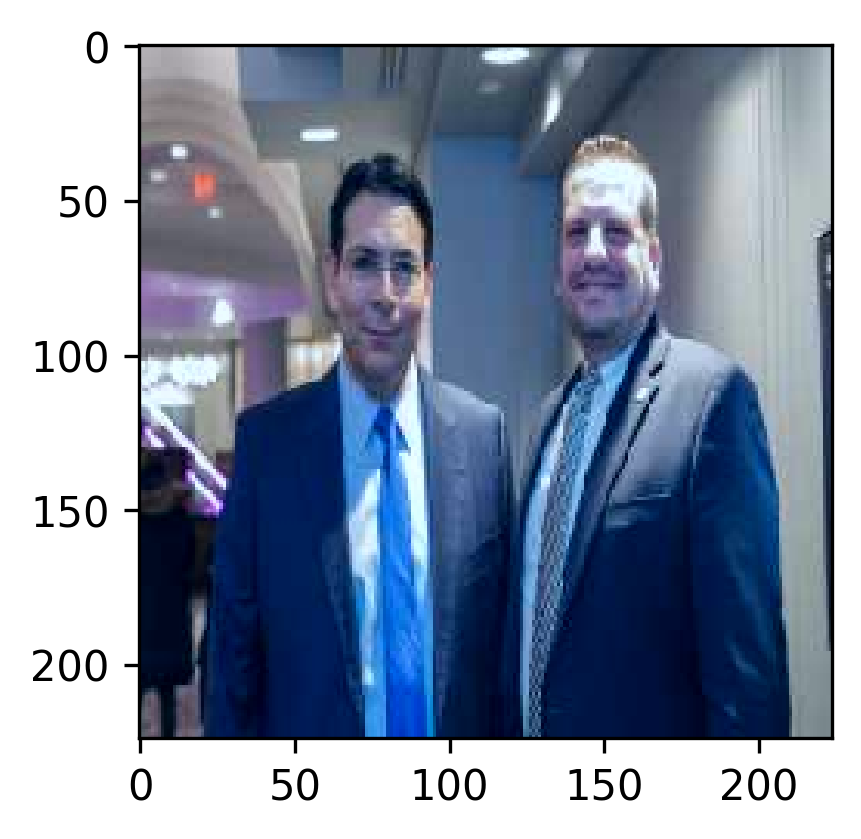

Image 8: Predicted Class: gideon_saar, True Class: ofir_akunis, Confidence: 0.2339


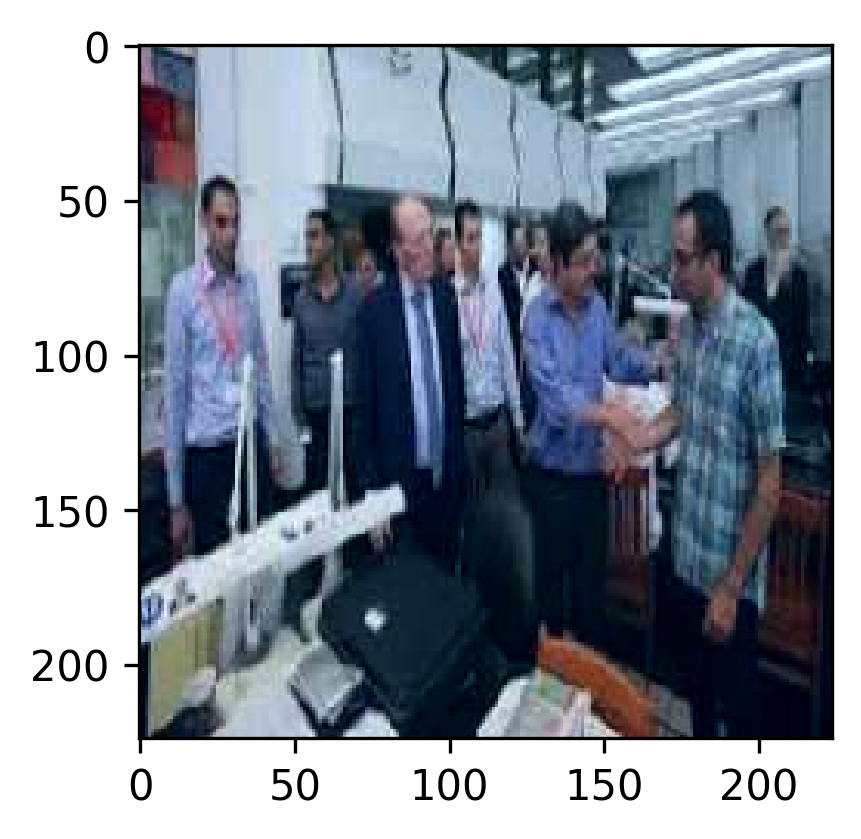

Image 9: Predicted Class: yair_lapid, True Class: ayelet_shaked, Confidence: 0.2334


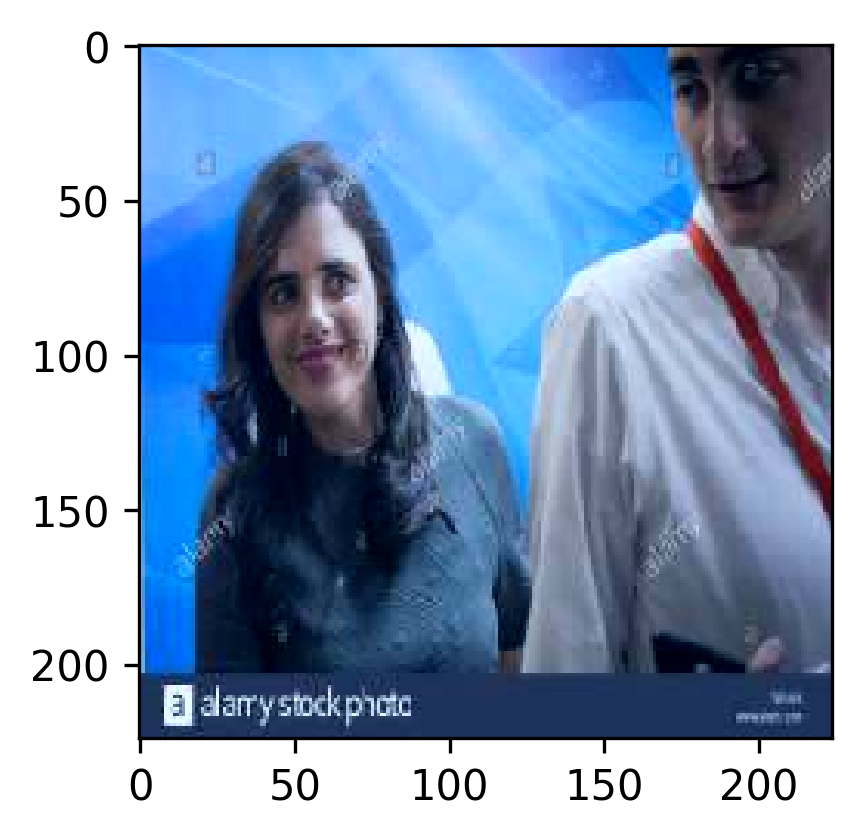

Image 10: Predicted Class: ofir_akunis, True Class: gideon_saar, Confidence: 0.2309


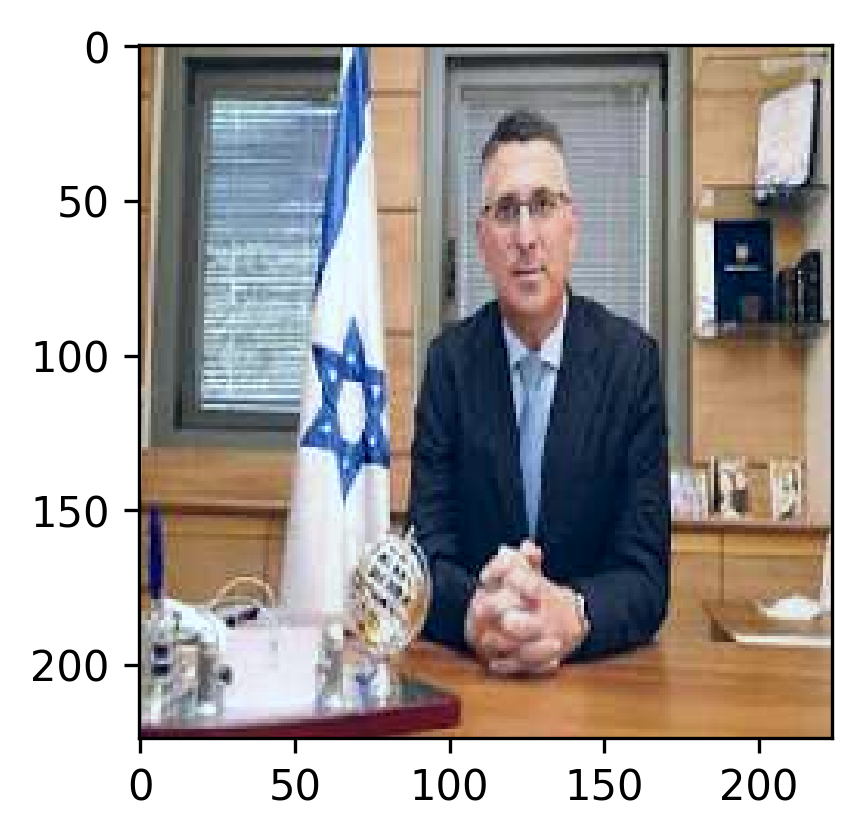

In [ ]:
# use top_incorrect_images to get top-10 errors
incorrect_images = get_errors(model_finetuned, validation_generator, steps)
top_incorrect_images(incorrect_images, class_names, MODEL_NAME)